# SEIAQRDVT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import deepxde as dde
import seaborn as sns

from deepxde.backend import tf
from scipy.integrate import odeint

sns.set_theme(style="darkgrid")
sns.set(rc={"figure.facecolor":"white"})

# dde.config.real.set_float64()
%matplotlib inline

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2022-07-08 19:48:21.036147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-08 19:48:21.068139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-08 19:48:21.068536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Model

$$
\begin{aligned}
\dot{S_1} &= - \frac{\beta_1}{N_1} S_1 (I_1^A + I_1^S) - \alpha_1 S_1 - \tau_{1,2} S_1 + \tau_{2,1} S_2\\[.5em]
\dot{E_1} &= \frac{\beta_1}{N_1} S_1 (I_1^A + I_1^S) - \sigma_1 E_1 - \tau_{1,2} E_1 + \tau_{2,1} E_2\\[.5em]
\dot{I_1^S} &= p_1 \sigma_1 E_1 + (1 - \nu_1 ) \omega_1 I_1^A - \xi_1 I_1^S - \tau_{1,2} I_1^S + \tau_{2,1} I_2^S\\[.5em]
\dot{I_1^A} &= (1 - p_1) \sigma_1 E_1 - \omega_1 I_1^A - \tau_{1,2} I^A_1 + \tau_{2,1} I^A_2\\[.5em]
\dot{Q_1} &= \xi_1 I_1^S - \gamma_1 Q_1 - \tau_{1,2} Q_1 + \tau_{2,1} Q_2\\[.5em]
\dot{R_1} &= \nu_1 \omega_1 I_1^A + (1 - q_1) \gamma_1 Q_1 - \tau_{1,2} R_1 + \tau_{2,1} R_2\\[.5em]
\dot{D_1} &= q_1 \gamma_1 Q_1\\[.5em]
\dot{V_1} &= \alpha_1 S_1 - \tau_{1,2} V_1 + \tau_{2,1} V_2\\[.5em]
\\
\dot{S_2} &= - \frac{\beta_2}{N_2} S_2 (I_2^A + I_2^S) - \alpha_2 S_2 - \tau_{2,1} S_2+ \tau_{1,2} S_1 \\[.5em]
\dot{E_2} &= \frac{\beta_2}{N_2} S_2 (I_2^A + I_2^S) - \sigma_2 E_2 - \tau_{2,1} E_2+ \tau_{1,2} E_1 \\[.5em]
\dot{I_2^S} &= p_2 \sigma_2 E_2 + (1 - \nu_2 ) \omega_2 I_2^A - \xi_2 I_2^S - \tau_{2,1} I^S_2+ \tau_{1,2} I^S_1\\[.5em]
\dot{I_2^A} &= (1 - p_2) \sigma_2 E_2 - \omega_2 I_2^A - \tau_{2,1} I^A_2+ \tau_{1,2} I^A_1\\[.5em]
\dot{Q_2} &= \xi_2 I_2^S - \gamma_2 Q_2 - \tau_{2,1} Q_2+ \tau_{1,2} Q_1\\[.5em]
\dot{R_2} &= \nu_2 \omega_2 I_2^A + (1 - q_2) \gamma_2 Q_2 - \tau_{2,1} R_2+ \tau_{1,2} R_1\\[.5em]
\dot{D_2} &= q_2 \gamma_2 Q_2\\[.5em]
\dot{V_2} &= \alpha_2 S_2 - \tau_{2,1} V_2+ \tau_{1,2} V_1
\end{aligned}
$$

- Susceptible (S): Individuals who have not been infected with COVID-19 and have not isolated themselves
from the population
- Exposed (E): Individuals in the incubation period of disease progression
- Asymptomatic (IA): Infectious individuals who do not show symptoms of COVID-19
- Symptomatic (IS): Infectious individuals who show symptoms of COVID-19
- Hospitalized (H): Infectious individuals, hospitalized with symptoms of COVID-19
- Quarantine (Q): Symptomatic infectious individuals who are isolated
- Recovered (R): Individuals who survived COVID-19
- Dead (D): Individuals who did not survive COVID-19

- $\beta$ Transmission Rate
- $\sigma$ Rate at which Exposed individuals become Infected
- $\omega$: Rate at which Asymptomatic individuals become Symptomatic or Recovered
- $\xi$: Rate at which Symptomatic individuals become Quarantined
- $\gamma$: Rate at which Quarantined individuals become Dead or Recovered
- $p$: Fraction of Symptomatic individuals out of Exposed individuals
- $q$: Fraction of Dead individuals out of Quarantined individuals
- $\nu$: Fraction of Recovered individuals out of Asymptomatic individuals
- $\alpha$: Vaccination Rate

## Initial Conditions

In [2]:
N1 = 1e7
N2 = 9e6
beta1 = 0.5
sigma1 = 1 / 6
omega1 = 1 / 14
xi1 = 0.5
gamma1 = 1 / 5
p1 = 0.6
q1 = 0.19
nu1 = 0.8
alpha1 = 0.01
beta2 = 0.5
sigma2 = 1 / 6
omega2 = 1 / 14
xi2 = 0.5
gamma2 = 1 / 5
p2 = 0.6
q2 = 0.19
nu2 = 0.8
alpha2 = 0.01
tau12 = 0.03
tau21 = 0.02
parameters_real = [
  beta1,
  sigma1,
  omega1,
  xi1,
  gamma1,
  p1,
  q1,
  nu1,
  alpha1,
  beta2,
  sigma2,
  omega2,
  xi2,
  gamma2,
  p2,
  q2,
  nu2,
  alpha2,
  tau12,
  tau21,
]

t = np.arange(0, 300, 10)[:, np.newaxis]

## Generate Data

In [3]:
def seiaqrdvt_model(
    t,
    N1,
    N2,
    beta1,
    sigma1,
    omega1,
    xi1,
    gamma1,
    p1,
    q1,
    nu1,
    alpha1,
    beta2,
    sigma2,
    omega2,
    xi2,
    gamma2,
    p2,
    q2,
    nu2,
    alpha2,
    tau12,
    tau21
):
    def func(y, t):
        S1, E1, I1, A1, Q1, R1, D1, V1, S2, E2, I2, A2, Q2, R2, D2, V2 = y
        
        dS1 = - beta1 / N1 * S1 * (I1 + A1) - alpha1 * S1 - tau12 * S1 + tau21 * S2
        dE1 = beta1 / N1 * S1 * (I1 + A1) - sigma1 * E1 - tau12 * E1 + tau21 * E2
        dI1 = p1 * sigma1 * E1 + (1 - nu1) * omega1 * A1 - xi1 * I1 - tau12 * I1 + tau21 * I2
        dA1 = (1 - p1) * sigma1 * E1 - omega1 * A1 - tau12 * A1 + tau21 * A2
        dQ1 = xi1 * I1 - gamma1 * Q1 - tau12 * Q1 + tau21 * Q2
        dR1 = nu1 * omega1 * A1 + (1 - q1) * gamma1 * Q1 - tau12 * R1 + tau21 * R2
        dD1 = q1 * gamma1 * Q1
        dV1 = alpha1 * S1 - tau12 * V1 + tau21 * V2   
        dS2 = - beta2 / N2 * S2 * (I2 + A2) - alpha2 * S2 - tau21 * S2 + tau12 * S1
        dE2 = beta2 / N2 * S2 * (I2 + A2) - sigma2 * E2 - tau21 * E2 + tau12 * E1
        dI2 = p2 * sigma2 * E2 + (1 - nu2) * omega2 * A2 - xi2 * I2 - tau21 * I2 + tau12 * I1
        dA2 = (1 - p2) * sigma2 * E2 - omega2 * A2 - tau21 * A2 + tau12 * A1
        dQ2 = xi2 * I2 - gamma2 * Q2 - tau21 * Q2 + tau12 * Q1
        dR2 = nu2 * omega2 * A2 + (1 - q2) * gamma2 * Q2 - tau21 * R2 + tau12 * R1
        dD2 = q2 * gamma2 * Q2
        dV2 = alpha2 * S2 - tau21 * V2 + tau12 * V1
        return [
                dS1, dE1, dI1, dA1, dQ1, dR1, dD1, dV1,
                dS2, dE2, dI2, dA2, dQ2, dR2, dD2, dV2
        ]
    
    S1_0 = N1 - 1000
    E1_0 = 1000
    I1_0 = 0
    A1_0 = 0
    Q1_0 = 0
    R1_0 = 0
    D1_0 = 0
    V1_0 = 0
    
    S2_0 = N2 - 1000
    E2_0 = 1000
    I2_0 = 0
    A2_0 = 0
    Q2_0 = 0
    R2_0 = 0
    D2_0 = 0
    V2_0 = 0

    y0 = [
          S1_0, E1_0, I1_0, A1_0, Q1_0, R1_0, D1_0, V1_0,
          S2_0, E2_0, I2_0, A2_0, Q2_0, R2_0, D2_0, V2_0
    ]
    return odeint(func, y0, t)

In [4]:
y = seiaqrdvt_model(
    np.ravel(t),
    N1,
    N2,
    beta1,
    sigma1,
    omega1,
    xi1,
    gamma1,
    p1,
    q1,
    nu1,
    alpha1,
    beta2,
    sigma2,
    omega2,
    xi2,
    gamma2,
    p2,
    q2,
    nu2,
    alpha2,
    tau12,
    tau21
)
y_noise1 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.01
y_noise5 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.05
y_noise10 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.1

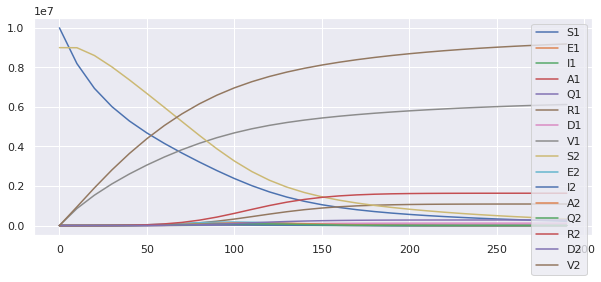

In [5]:
names = ["S1", "E1", "I1", "A1", "Q1", "R1", "D1", "V1", "S2", "E2", "I2", "A2", "Q2", "R2", "D2", "V2"]
fig, ax = plt.subplots(figsize=(10, 4))
for v, name in zip(y.T, names):
    ax.plot(np.ravel(t), v, label=name)
plt.legend()
plt.show()

## DINN

In [6]:
def dinn(data_t, data_y, N1, N2):    
    
    # Variables
    beta1 = tf.math.sigmoid(dde.Variable(0.1))
    sigma1 = tf.math.sigmoid(dde.Variable(0.1))
    omega1 = tf.math.sigmoid(dde.Variable(0.1))
    xi1 = tf.math.sigmoid(dde.Variable(0.1))
    gamma1 = tf.math.sigmoid(dde.Variable(0.1))
    p1 = tf.math.sigmoid(dde.Variable(0.1))
    q1 = tf.math.sigmoid(dde.Variable(0.1))
    nu1 = tf.math.sigmoid(dde.Variable(0.1))
    alpha1 = tf.math.sigmoid(dde.Variable(0.1))
    beta2 = tf.math.sigmoid(dde.Variable(0.1))
    sigma2 = tf.math.sigmoid(dde.Variable(0.1))
    omega2 = tf.math.sigmoid(dde.Variable(0.1))
    xi2 = tf.math.sigmoid(dde.Variable(0.1))
    gamma2 = tf.math.sigmoid(dde.Variable(0.1))
    p2 = tf.math.sigmoid(dde.Variable(0.1))
    q2 = tf.math.sigmoid(dde.Variable(0.1))
    nu2 = tf.math.sigmoid(dde.Variable(0.1))
    alpha2 = tf.math.sigmoid(dde.Variable(0.1))
    tau12 = tf.math.sigmoid(dde.Variable(0.1))
    tau21 = tf.math.sigmoid(dde.Variable(0.1))

    variable_list = [
      beta1,
      sigma1,
      omega1,
      xi1,
      gamma1,
      p1,
      q1,
      nu1,
      alpha1,
      beta2,
      sigma2,
      omega2,
      xi2,
      gamma2,
      p2,
      q2,
      nu2,
      alpha2,
      tau12,
      tau21,
    ]

    # ODE model
    def ODE(t, y):
        S1 = y[:, 0:1]
        E1 = y[:, 1:2]
        I1 = y[:, 2:3]
        A1 = y[:, 3:4]
        Q1 = y[:, 4:5]
        R1 = y[:, 5:6]
        D1 = y[:, 6:7]
        V1 = y[:, 7:8]
        
        S2 = y[:, 8:9]
        E2 = y[:, 9:10]
        I2 = y[:, 10:11]
        A2 = y[:, 11:12]
        Q2 = y[:, 12:13]
        R2 = y[:, 13:14]
        D2 = y[:, 14:15]
        V2 = y[:, 15:16]
        
        dS1_t = dde.grad.jacobian(y, t, i=0)
        dE1_t = dde.grad.jacobian(y, t, i=1)
        dI1_t = dde.grad.jacobian(y, t, i=2)
        dA1_t = dde.grad.jacobian(y, t, i=3)
        dQ1_t = dde.grad.jacobian(y, t, i=4)
        dR1_t = dde.grad.jacobian(y, t, i=5)
        dD1_t = dde.grad.jacobian(y, t, i=6)
        dV1_t = dde.grad.jacobian(y, t, i=7)
        
        dS2_t = dde.grad.jacobian(y, t, i=8)
        dE2_t = dde.grad.jacobian(y, t, i=9)
        dI2_t = dde.grad.jacobian(y, t, i=10)
        dA2_t = dde.grad.jacobian(y, t, i=11)
        dQ2_t = dde.grad.jacobian(y, t, i=12)
        dR2_t = dde.grad.jacobian(y, t, i=13)
        dD2_t = dde.grad.jacobian(y, t, i=14)
        dV2_t = dde.grad.jacobian(y, t, i=15)
        
        return [
          dS1_t - (- beta1 / N1 * S1 * (I1 + A1) - alpha1 * S1 - tau12 * S1 + tau21 * S2),
          dE1_t - (beta1 / N1 * S1 * (I1 + A1) - sigma1 * E1 - tau12 * E1 + tau21 * E2),
          dI1_t - (p1 * sigma1 * E1 + (1 - nu1) * omega1 * A1 - xi1 * I1 - tau12 * I1 + tau21 * I2),
          dA1_t - ((1 - p1) * sigma1 * E1 - omega1 * A1 - tau12 * A1 + tau21 * A2),
          dQ1_t - (xi1 * I1 - gamma1 * Q1 - tau12 * Q1 + tau21 * Q2),
          dR1_t - (nu1 * omega1 * A1 + (1 - q1) * gamma1 * Q1 - tau12 * R1 + tau21 * R2),
          dD1_t - (q1 * gamma1 * Q1),
          dV1_t - (alpha1 * S1 - tau12 * V1 + tau21 * V2   ),
          dS2_t - (- beta2 / N2 * S2 * (I2 + A2) - alpha2 * S2 - tau21 * S2 + tau12 * S1),
          dE2_t - (beta2 / N2 * S2 * (I2 + A2) - sigma2 * E2 - tau21 * E2 + tau12 * E1),
          dI2_t - (p2 * sigma2 * E2 + (1 - nu2) * omega2 * A2 - xi2 * I2 - tau21 * I2 + tau12 * I1),
          dA2_t - ((1 - p2) * sigma2 * E2 - omega2 * A2 - tau21 * A2 + tau12 * A1),
          dQ2_t - (xi2 * I2 - gamma2 * Q2 - tau21 * Q2 + tau12 * Q1),
          dR2_t - (nu2 * omega2 * A2 + (1 - q2) * gamma2 * Q2 - tau21 * R2 + tau12 * R1),
          dD2_t - (q2 * gamma2 * Q2),
          dV2_t - (alpha2 * S2 - tau21 * V2 + tau12 * V1)
        ]
    
    # Geometry
    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])
    
    # Boundaries
    def boundary(_, on_initial):
        return on_initial
    
    # Initial conditions
    ic_S1 = dde.icbc.IC(geom, lambda x: N1- 1000, boundary, component=0)
    ic_E1 = dde.icbc.IC(geom, lambda x: 1000, boundary, component=1)
    ic_I1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=2)
    ic_A1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=3)
    ic_Q1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=4)
    ic_R1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=5)
    ic_D1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=6)
    ic_V1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=7)

    ic_S2 = dde.icbc.IC(geom, lambda x: N2- 1000, boundary, component=8)
    ic_E2 = dde.icbc.IC(geom, lambda x: 1000, boundary, component=9)
    ic_I2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=10)
    ic_A2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=11)
    ic_Q2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=12)
    ic_R2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=13)
    ic_D2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=14)
    ic_V2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=15)

    # Train data
    observe_S1 = dde.icbc.PointSetBC(data_t, data_y[:, 0:1], component=0)
    observe_E1 = dde.icbc.PointSetBC(data_t, data_y[:, 1:2], component=1)
    observe_I1 = dde.icbc.PointSetBC(data_t, data_y[:, 2:3], component=2)
    observe_A1 = dde.icbc.PointSetBC(data_t, data_y[:, 3:4], component=3)
    observe_Q1 = dde.icbc.PointSetBC(data_t, data_y[:, 4:5], component=4)
    observe_R1 = dde.icbc.PointSetBC(data_t, data_y[:, 5:6], component=5)
    observe_D1 = dde.icbc.PointSetBC(data_t, data_y[:, 6:7], component=6)
    observe_V1 = dde.icbc.PointSetBC(data_t, data_y[:, 7:8], component=7)
    
    observe_S2 = dde.icbc.PointSetBC(data_t, data_y[:, 8:9], component=8)
    observe_E2 = dde.icbc.PointSetBC(data_t, data_y[:, 9:10], component=9)
    observe_I2 = dde.icbc.PointSetBC(data_t, data_y[:, 10:11], component=10)
    observe_A2 = dde.icbc.PointSetBC(data_t, data_y[:, 11:12], component=11)
    observe_Q2 = dde.icbc.PointSetBC(data_t, data_y[:, 12:13], component=12)
    observe_R2 = dde.icbc.PointSetBC(data_t, data_y[:, 13:14], component=13)
    observe_D2 = dde.icbc.PointSetBC(data_t, data_y[:, 14:15], component=14)
    observe_V2 = dde.icbc.PointSetBC(data_t, data_y[:, 15:16], component=15)

    # Model
    data = dde.data.PDE(
        geom,
        ODE,
        [
            ic_S1,
            ic_E1,
            ic_I1,
            ic_A1,
            ic_Q1,
            ic_R1,
            ic_D1,
            ic_V1,
            ic_S2,
            ic_E2,
            ic_I2,
            ic_A2,
            ic_Q2,
            ic_R2,
            ic_D2,
            ic_V2,
            observe_S1,
            # observe_E1,
            observe_I1,
            # observe_A1,
            observe_Q1,
            # observe_R1,
            observe_D1,
            observe_V1,
            observe_S2,
            # observe_E2,
            observe_I2,
            # observe_A2,
            observe_Q2,
            # observe_R2,
            observe_D2,
            observe_V2
        ],
        num_domain=400,
        num_boundary=2,
        anchors=data_t,
    )
    
    net = dde.nn.FNN([1] + [128] * 6 + [16], "relu", "Glorot uniform")

    def feature_transform(t):
        t = t / data_t[-1, 0]
        return t

    net.apply_feature_transform(feature_transform)

    iterations = 100000
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        loss_weights=16 * [1] + 16 * [5] + 10 * [6],
        external_trainable_variables=variable_list,
    )

    variablefilename = "variables_seiaqrdvt.csv"
    variable = dde.callbacks.VariableValue(
        variable_list, period=5000, filename=variablefilename
    )
    losshistory, train_state = model.train(
        iterations=iterations, display_every=10000, callbacks=[variable]
    )
    dde.saveplot(losshistory, train_state, issave=False, isplot=False)
    return model, variable

In [7]:
model, variable = dinn(t, y, N1, N2)

Compiling model...
Building feed-forward neural network...
'build' took 0.053781 s



/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  warnings.warn("The balance properties of Sobol' points require "
/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-07-08 19:48:22.051337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-08 19:48:22.054761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] cou

'compile' took 3.038184 s

Initializing variables...


2022-07-08 19:48:25.088607: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-07-08 19:48:25.249990: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f915c020ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-07-08 19:48:25.250056: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2022-07-08 19:48:25.430577: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-08 19:48:25.491792: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training model...



2022-07-08 19:48:25.687713: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Step      Train loss                                                                                                                                                                                                                                                                                                                                                                                                                              Test loss                                                                                                                                                                                                                                                                                                                                                                                                                               Test metric
0         [5.55e-04, 6.43e-04, 6.95e-04, 2.36e-04, 4.83e-04, 5.29e-04, 6.41e-07, 2.52e-05, 1.05e-03, 7.19e-04, 4.79e-05, 3.30e-06,

2022-07-08 19:48:36.585613: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'input_fusion_reduce_87', 40 bytes spill stores, 36 bytes spill loads



10000     [2.38e+09, 2.30e+08, 2.53e+08, 3.46e+08, 7.83e+07, 4.82e+08, 4.09e+05, 6.74e+09, 1.54e+08, 1.70e+08, 9.77e+07, 1.08e+08, 1.85e+07, 2.26e+08, 2.58e+06, 5.62e+09, 7.55e+08, 5.53e+07, 2.67e+06, 1.51e+08, 1.93e+06, 5.05e+07, 1.66e+06, 2.24e+08, 2.37e+07, 7.95e+07, 1.46e+06, 5.30e+07, 2.45e+05, 8.98e+07, 7.80e+05, 2.56e+08, 3.71e+09, 8.12e+07, 4.12e+08, 2.80e+08, 2.83e+08, 2.13e+09, 3.12e+08, 1.91e+09, 1.03e+09, 6.55e+08]    [2.38e+09, 2.30e+08, 2.53e+08, 3.46e+08, 7.83e+07, 4.82e+08, 4.09e+05, 6.74e+09, 1.54e+08, 1.70e+08, 9.77e+07, 1.08e+08, 1.85e+07, 2.26e+08, 2.58e+06, 5.62e+09, 7.55e+08, 5.53e+07, 2.67e+06, 1.51e+08, 1.93e+06, 5.05e+07, 1.66e+06, 2.24e+08, 2.37e+07, 7.95e+07, 1.46e+06, 5.30e+07, 2.45e+05, 8.98e+07, 7.80e+05, 2.56e+08, 3.71e+09, 8.12e+07, 4.12e+08, 2.80e+08, 2.83e+08, 2.13e+09, 3.12e+08, 1.91e+09, 1.03e+09, 6.55e+08]    []  
20000     [4.14e+07, 5.51e+07, 5.84e+05, 1.33e+08, 1.26e+05, 1.56e+07, 1.48e+05, 1.24e+07, 1.53e+08, 6.81e+07, 9.81e+05, 3.58e+07, 1.45e+

## Postprocessing

In [8]:
parameter_names = [
  "beta_1",
  "sigma_1",
  "omega_1",
  "xi_1",
  "gamma_1",
  "p_1",
  "q_1",
  "nu_1",
  "alpha_1",
  "beta_2",
  "sigma_2",
  "omega_2",
  "xi_2",
  "gamma_2",
  "p_2",
  "q_2",
  "nu_2",
  "alpha_2",
  "tau_12",
  "tau_21"
]
errors = (
    pd.DataFrame(
        {
            "real": parameters_real,
            "predicted": variable.value
        },
        index=parameter_names
    )
    .assign(
        relative_error=lambda x: (x["real"] - x["predicted"]).abs() / x["real"] * 100
    )
)
errors.to_excel("SEIAQRDVT_errors.xlsx")
errors

,real,predicted,relative_error
beta_1,0.500000,1.851611e-01,62.967789
sigma_1,0.166667,4.892995e-04,99.706420
omega_1,0.071429,3.980397e-16,100.000000
xi_1,0.500000,6.296859e-02,87.406282
gamma_1,0.200000,3.771588e-02,81.142059
p_1,0.600000,9.999979e-01,66.666309
q_1,0.190000,1.000000e+00,426.315789
nu_1,0.800000,9.999208e-01,24.990106
alpha_1,0.010000,9.517701e-03,4.822987
beta_2,0.500000,1.918117e-01,61.637655


In [9]:
print(
    errors.style
    .format(
        {
            "real": "{:.4f}",
            "predicted": "{:.4f}",
            "relative_error": "{:.2f}",
        }
    ).to_latex(
        label="tab:sirdt_errors",
        caption="Parameter predictions and relative errors.",   
    )
)

\begin{table}
\caption{Parameter predictions and relative errors.}
\label{tab:sirdt_errors}
\begin{tabular}{lrrr}
 & real & predicted & relative_error \\
beta_1 & 0.5000 & 0.1852 & 62.97 \\
sigma_1 & 0.1667 & 0.0005 & 99.71 \\
omega_1 & 0.0714 & 0.0000 & 100.00 \\
xi_1 & 0.5000 & 0.0630 & 87.41 \\
gamma_1 & 0.2000 & 0.0377 & 81.14 \\
p_1 & 0.6000 & 1.0000 & 66.67 \\
q_1 & 0.1900 & 1.0000 & 426.32 \\
nu_1 & 0.8000 & 0.9999 & 24.99 \\
alpha_1 & 0.0100 & 0.0095 & 4.82 \\
beta_2 & 0.5000 & 0.1918 & 61.64 \\
sigma_2 & 0.1667 & 0.0022 & 98.70 \\
omega_2 & 0.0714 & 0.0029 & 95.92 \\
xi_2 & 0.5000 & 0.0463 & 90.74 \\
gamma_2 & 0.2000 & 0.0256 & 87.18 \\
p_2 & 0.6000 & 0.2015 & 66.42 \\
q_2 & 0.1900 & 1.0000 & 426.32 \\
nu_2 & 0.8000 & 1.0000 & 25.00 \\
alpha_2 & 0.0100 & 0.0099 & 1.48 \\
tau_12 & 0.0300 & 0.0254 & 15.27 \\
tau_21 & 0.0200 & 0.0169 & 15.27 \\
\end{tabular}
\end{table}



In [10]:
status_names = ["S1", "I1", "Q1", "D1", "V1", "S2", "I2", "Q2", "D2", "V2"]

In [14]:
df_real = (
    pd.DataFrame(y, columns=names, index=t.ravel())
    .loc[:, status_names]
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status_zone", value_name="population")
    .assign(
        status=lambda x: x["status_zone"].str[0],
        zone=lambda x: x["status_zone"].str[1],
    )
)

y_pred = model.predict(t)
df_pred = (
    pd.DataFrame(y_pred, columns=names, index=t.ravel())
    .loc[:, status_names]
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status_zone", value_name="population")
    .assign(
        status=lambda x: x["status_zone"].str[0],
        zone=lambda x: x["status_zone"].str[1],
    )
)
df_pred.head()

,time,status_zone,population,status,zone
0,0,S1,10001194.0,S,1
1,10,S1,8193814.0,S,1
2,20,S1,6941239.0,S,1
3,30,S1,6016664.0,S,1
4,40,S1,5291215.5,S,1


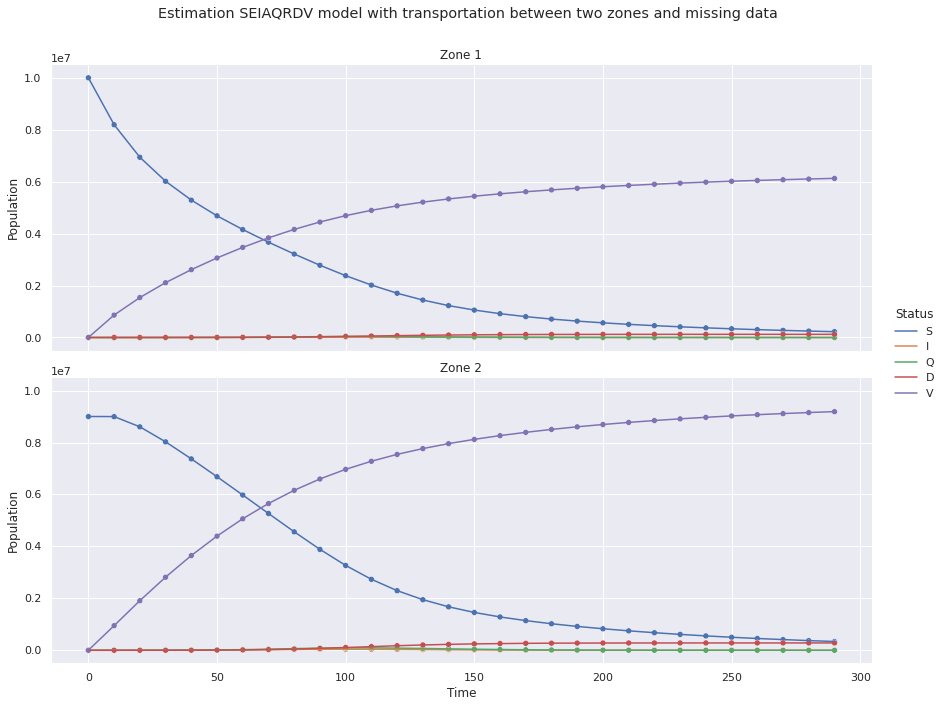

In [15]:
sns.set(rc={"figure.facecolor":"white"})

g = sns.relplot(
    data=df_pred,
    x="time",
    y="population",
    row="zone",
    hue="status",
    kind="line",
    aspect=2.5,
)

for zone, ax in g.axes_dict.items():
    sns.scatterplot(
        data=df_real.query("zone == @zone"),
        x="time",
        y="population",
        hue="status",
        ax=ax,
        legend=False
      )


(
    g.set_axis_labels("Time", "Population")
      .set_titles("Zone {row_name}")
      .tight_layout(w_pad=1)
)

g._legend.set_title("Status")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"Estimation SEIAQRDV model with transportation between two zones and missing data")
plt.savefig("SEIAQRDVT_missing_estimation.png", dpi=300)
plt.show()